# NLP Project IDCamp X Dicoding: Trip Advisor Hotel Reviews

- Name: Fajrul Iman Giat Koentjoro
- Email: fajrul.10.9e@gmail.com

## Preparing TPU

In [1]:
# Activating TPU
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  tpu = None
  print('TPU not found')

# Initiating TPU
if tpu != None:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.13.154.186:8470']


## Importing Library and Necessity

In [2]:
# Downloading nltk
import nltk
nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Importing Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile, os
import string
import re

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GlobalAveragePooling1D, Dropout, BatchNormalization, Bidirectional

In [4]:
# Preparing Kaggle API Token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Kaggle Dataset API
!kaggle datasets download -d andrewmvd/trip-advisor-hotel-reviews

trip-advisor-hotel-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


## Loading Dataset

In [6]:
# Extracting Dataset
local_zip = "/content/trip-advisor-hotel-reviews.zip"

zip_reff = zipfile.ZipFile(local_zip, 'r')
zip_reff.extractall("/content")
zip_reff.close()

In [7]:
#Reading the dataset
raw_df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
raw_df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Exoloratory Data Analysis

### Cleaning the Data

In [8]:
df = raw_df.copy()
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [10]:
print("==========Check Null Data==========")
df.isnull().sum()

==========Check Null Data==========


Review    0
Rating    0
dtype: int64

In [11]:
df[df.isnull().any(axis=1)]

,Review,Rating


From the information above, it is known that there is no null data in the dataset used, besides that there is also no data type error in the dataset feature

In [12]:
#Run this code if there is null data in the dataset
# df.Review.fillna('No comments', inplace=True)

# print("==========Check Null Data==========")
# print(df.isnull().sum())

The code above will change or fill null data with 'No comments', Because the cause of null data is possibly because the rater did not comment on his post.

In [13]:
# Changing the 5 stars rating into 3 categories
def rating(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

The 3-star rating is Neutral, so above it is positive, and below it is negative

In [14]:
#Apply the rating function to dataset
df['Rating'] = df['Rating'].apply(rating)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Negative
2,nice rooms not 4* experience hotel monaco seat...,Neutral
3,"unique, great stay, wonderful time hotel monac...",Positive
4,"great stay great stay, went seahawk game aweso...",Positive


In [15]:
# Handling punctuations, emoji and uppercase
def remove_punct(text):
    # Replace punctuation with spaces
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    clean_text = text.translate(translator).lower()

    # Remove multiple consecutive spaces
    clean_text = ' '.join(clean_text.split())

    #Remove emoji
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    return clean_text

df['Review'] = df['Review'].apply(remove_punct)
df.Review.iloc[400]

'great stay got decent price standard room king bed 175 taxes stayed night just christmas service impeccable ç ærom bell hops concierge sean really helpful decor gorgeous location perfect close shops restaurants excellent hotel highly recommended'

In [16]:
# Remove Stopwords

def remove_stopwords(text):
  clean_text = [word for word in text.split() if word not in stopwords.words('english')]
  return ' '.join(clean_text)

df['Review'] = df['Review'].apply(remove_stopwords)
df.Review.iloc[400]

'great stay got decent price standard room king bed 175 taxes stayed night christmas service impeccable ç ærom bell hops concierge sean really helpful decor gorgeous location perfect close shops restaurants excellent hotel highly recommended'

In [17]:
# Lemmatization to reduce the text lenght

def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  lemmatized_text = [lemmatizer.lemmatize(word, 'v') for word in text.split()]
  return ' '.join(lemmatized_text)

df['Review'] = df['Review'].apply(lemmatization)
df.Review.iloc[400]

'great stay get decent price standard room king bed 175 tax stay night christmas service impeccable ç ærom bell hop concierge sean really helpful decor gorgeous location perfect close shop restaurants excellent hotel highly recommend'

The purpose of the 3 functions above is to clean data from punctuation and useless symbols, as well as to reduce text length by removing words that do not have a large contribution in a text (Stopwords) and changing all verbs to the first form of the verb

### Data Pre-processing

In [18]:
#Encode the label into one-hot encoding
category = pd.get_dummies(df.Rating)
encoded_df = pd.concat([df, category], axis=1)
encoded_df = encoded_df.drop(columns='Rating')
encoded_df.head()

,Review,Negative,Neutral,Positive
0,nice hotel expensive park get good deal stay h...,0,0,1
1,ok nothing special charge diamond member hilto...,1,0,0
2,nice room 4 experience hotel monaco seattle go...,0,1,0
3,unique great stay wonderful time hotel monaco ...,0,0,1
4,great stay great stay go seahawk game awesome ...,0,0,1


In [19]:
#Separating the labels and the features
reviews = encoded_df['Review'].values
labels = encoded_df[['Negative', 'Neutral', 'Positive']].values

In [20]:
# Split the data into training data and test/validation data
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, stratify=labels, random_state=42)

In [21]:
#Tokenizing the data
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index)+1

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [22]:
# Analyzing the length of the sequence to find out the appropriate padding length
seq_df = pd.DataFrame(np.array(train_sequences), columns=['Sequences'])
seq_df['Length'] = seq_df['Sequences'].apply(len)
seq_df

<ipython-input-22-48e9ac0b71f7>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_df = pd.DataFrame(np.array(train_sequences), columns=['Sequences'])


,Sequences,Length
0,"[38, 230, 946, 14751, 4, 81, 72, 176, 728, 557...",39
1,"[5, 9, 23, 225, 222, 236, 447, 502, 48, 219, 3...",254
2,"[10, 2, 4, 10, 3, 93, 57, 13, 70, 130, 449, 39...",89
3,"[690, 113, 123, 1180, 1455, 225, 222, 71, 110,...",296
4,"[530, 4, 2629, 6951, 1257, 812, 550, 4, 134, 2...",105
...,...,...
16387,"[7, 2, 7, 11, 4, 5076, 46, 101, 1144, 117, 3, ...",46
16388,"[121, 11, 175, 6833, 844, 97, 185, 995, 495, 4...",143
16389,"[923, 83, 1486, 366, 2, 1278, 600, 1120, 1066,...",34
16390,"[359, 172, 147, 15, 271, 557, 2, 2970, 47, 3, ...",58


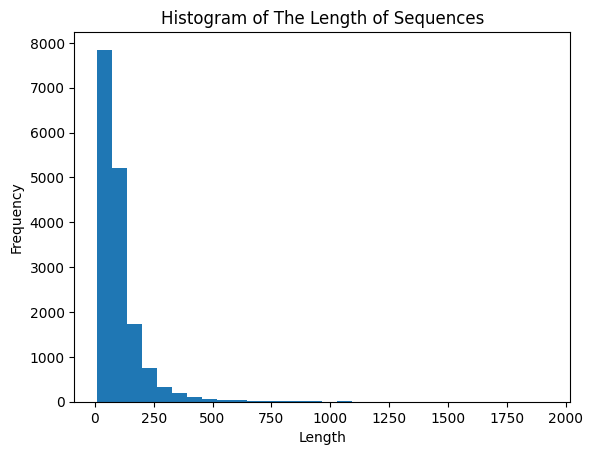

In [23]:
# Generating Histogram
plt.hist(seq_df['Length'], bins=30)
plt.title('Histogram of The Length of Sequences')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.show()


From the information above, it is known that the majority of data with a frequency range of around 1000 data are data with sequence lengths below 250

In [24]:
# Padding the data
padded_train = pad_sequences(train_sequences,
                             maxlen=250,
                             padding='pre',
                             truncating='post'
               )

padded_test = pad_sequences(test_sequences,
                            maxlen=250,
                            padding='pre',
                            truncating='post'
              )

## Modeling

In [25]:
# Creating the sequential model and runing it on TPU
with tpu_strategy.scope():
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = 250))
  model.add(SpatialDropout1D(0.4))
  model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
  model.add(GlobalAveragePooling1D())
  model.add(BatchNormalization())
  model.add(Dense(32, activation='elu' ,kernel_regularizer=l2(0.05), bias_regularizer=l2(0.05)))
  model.add(Dropout(0.5))
  model.add(Dense(3,activation='softmax'))

  print(model.summary())

  model.compile(loss = 'categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                  epsilon=1.e-7),
                metrics = ['accuracy']
  )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          5153408   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 128)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         98816     
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                          

In [26]:
# Callback for early stoping when the accuracy has reached above 0.85
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.85 and logs.get('val_accuracy')>=0.85):
      print("\nYour accuracy has reached >85%!")
      self.model.stop_training = True

In [27]:
# Callback for Learning rate scheduler
from tensorflow.keras.callbacks import LearningRateScheduler
import math

initial_learning_rate = 0.00007

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 7
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

### Training

In [28]:
# Fit the model on TPU
num_epochs = 30
num_batch = 64

with tpu_strategy.scope():
  history = model.fit(padded_train, y_train,
                      epochs=num_epochs,
                      batch_size=num_batch,
                      validation_data=(padded_test, y_test),
                      verbose=2,
                      callbacks=[[LearningRateScheduler(lr_step_decay), myCallback()]]
            )

Epoch 1/30
257/257 - 52s - loss: 3.4919 - accuracy: 0.4109 - val_loss: 3.0241 - val_accuracy: 0.7365 - lr: 7.0000e-05 - 52s/epoch - 204ms/step
Epoch 2/30
257/257 - 20s - loss: 2.8174 - accuracy: 0.5865 - val_loss: 2.5100 - val_accuracy: 0.7365 - lr: 7.0000e-05 - 20s/epoch - 80ms/step
Epoch 3/30
257/257 - 20s - loss: 2.2976 - accuracy: 0.7191 - val_loss: 2.0252 - val_accuracy: 0.7624 - lr: 7.0000e-05 - 20s/epoch - 80ms/step
Epoch 4/30
257/257 - 21s - loss: 1.8720 - accuracy: 0.7779 - val_loss: 1.6016 - val_accuracy: 0.7946 - lr: 7.0000e-05 - 21s/epoch - 81ms/step
Epoch 5/30
257/257 - 21s - loss: 1.5200 - accuracy: 0.8098 - val_loss: 1.2967 - val_accuracy: 0.8326 - lr: 7.0000e-05 - 21s/epoch - 80ms/step
Epoch 6/30
257/257 - 20s - loss: 1.2549 - accuracy: 0.8231 - val_loss: 1.0795 - val_accuracy: 0.8441 - lr: 7.0000e-05 - 20s/epoch - 79ms/step
Epoch 7/30
257/257 - 21s - loss: 1.0444 - accuracy: 0.8334 - val_loss: 0.9123 - val_accuracy: 0.8390 - lr: 7.0000e-05 - 21s/epoch - 80ms/step
Epoch

### Visualization/Evaluation

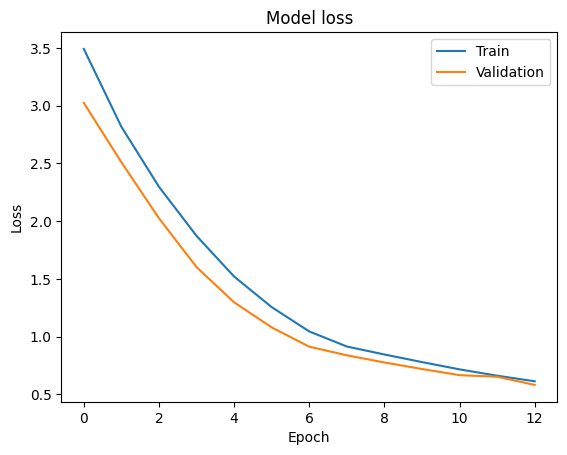

In [29]:
# Visualizing the loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

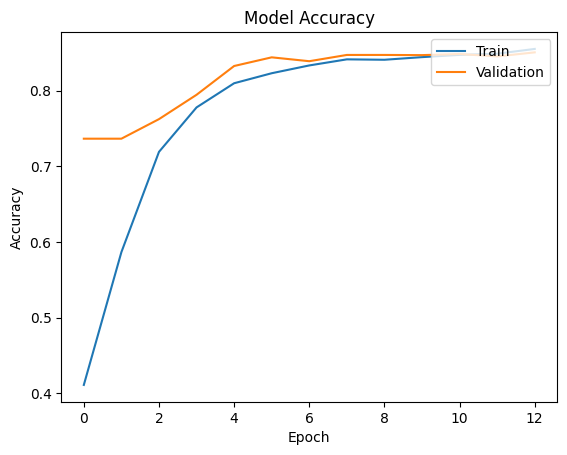

In [30]:
# Visualizing the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Summary: The maximum accuracy that can be obtained on this model after doing a lot of trial and error for tuning is approximately 0.85 for both training and validation accuracy. In addition, attempts have been made to use pre-trained BERT and Word2Vec, but the results obtained were not significant. Therefore, it can be concluded that an accuracy of 0.85 for three-class text classification is very good. This is also evidenced by the fact that I was unable to find an example of code or an open-source project on Kaggle and Internet that achieved an accuracy of 0.90 or more, unless they only used two-class classification.